In [163]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Creating spark session and loading data from hdfs

In [164]:
# Create spark session
spark = SparkSession.builder \
        .appName("Market Campaign Analysis") \
        .enableHiveSupport() \
        .getOrCreate()

# Define schema
schema = StructType([
    StructField("campaign_id", StringType(), True),
    StructField("campaign_name", StringType(), True),
    StructField("campaign_country", StringType(), True),
    StructField("os_type", StringType(), True),
    StructField("device_type", StringType(), True),
    StructField("place_id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("event_type", StringType(), True),
    StructField("event_time", TimestampType(), True)
])

# using external schema to create spark ad camapigns dataframe 
hdfs_path = "/input_data/ad_campaigns_data.json"
ad_campaigns_df = spark.read.format('json').option('multiline', 'true').option('inferSchema', 'false').schema(schema).load(hdfs_path)

# print schema
ad_campaigns_df.printSchema()

# print data
ad_campaigns_df.show()

root
 |-- campaign_id: string (nullable = true)
 |-- campaign_name: string (nullable = true)
 |-- campaign_country: string (nullable = true)
 |-- os_type: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- place_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_time: timestamp (nullable = true)

+-----------+--------------------+----------------+-------+-----------+---------+-------------------+----------+-------------------+
|campaign_id|       campaign_name|campaign_country|os_type|device_type| place_id|            user_id|event_type|         event_time|
+-----------+--------------------+----------------+-------+-----------+---------+-------------------+----------+-------------------+
|    ABCDFAE|Food category tar...|             USA|    ios|      apple|CASSBB-11|1264374214654454321|impression|2018-10-12 13:10:05|
|    ABCDFAE|Food category tar...|             USA|android|   MOTOROLA|CADGBD-

In [165]:
# using inferschema utility to create spark users profile dataframe 
hdfs_path = '/input_data/user_profile_data.json'
users_profile_df = spark.read.format('json').option('multiline', 'true').option('inferSchema', 'true').load(hdfs_path)

# print schema
users_profile_df.printSchema()

# print data
users_profile_df.show()

root
 |-- age_group: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- country: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- user_id: string (nullable = true)

+---------+--------------------+-------+------+-------------------+
|age_group|            category|country|gender|            user_id|
+---------+--------------------+-------+------+-------------------+
|    18-25|  [shopper, student]|    USA|  male|1264374214654454321|
|    25-50|            [parent]|    USA|female|1674374214654454321|
|    25-50|[shopper, parent,...|    USA|  male|   5747421465445443|
|      50+|      [professional]|    USA|  male|1864374214654454132|
|    18-25|  [shopper, student]|    USA|female|  14537421465445443|
|      50+|[shopper, profess...|    USA|female|  25547421465445443|
+---------+--------------------+-------+------+-------------------+



In [166]:
# using inferschema utility to create stores dataframe
hdfs_path = "/input_data/store_data.json"
stores_df = spark.read.format('json').option('multiline', 'true').option('inferSchema', 'true').load(hdfs_path)

# print schema'
stores_df.printSchema()

# print data
stores_df.show()

root
 |-- place_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- store_name: string (nullable = true)

+--------------------+-------------+
|           place_ids|   store_name|
+--------------------+-------------+
|[CASSBB-11, CADGB...|     McDonald|
|         [CASSBB-11]|   BurgerKing|
|[BADGBA-13, CASSB...|        Macys|
|         [BADGBA-12]|shoppers stop|
+--------------------+-------------+



# Analysis

#### Q1. Analyse data for each campaign_id, date, hour, os_type & value to get all the events with counts

In [169]:
ad_campaigns_events = ad_campaigns_df \
        .withColumn('date', to_date(col('event_time'))) \
        .withColumn('hour', hour(col('event_time'))) \
        .withColumn('type', lit('os_type')) \
        .withColumn('value', col('os_type')) \
        .groupby('campaign_id', 'date', 'hour', 'type', 'value') \
        .agg(
        create_map(
            lit('impresssion'), count(when (col('event_type') == 'impression', True)),
            lit('click'), count(when (col('event_type') == 'click', True)),
            lit('video_ad'), count(when (col('event_type') == 'video_ad', True))
            )
        .alias('event'))

In [170]:
ad_campaigns_events.show(truncate=False)

+-----------+----------+----+-------+-------+---------------------------------------------+
|campaign_id|date      |hour|type   |value  |event                                        |
+-----------+----------+----+-------+-------+---------------------------------------------+
|ABCDFAE    |2018-10-12|13  |os_type|ios    |{impresssion -> 1, click -> 0, video_ad -> 0}|
|ABCDFAE    |2018-10-12|13  |os_type|android|{impresssion -> 1, click -> 1, video_ad -> 0}|
+-----------+----------+----+-------+-------+---------------------------------------------+



In [179]:
# writing output data to hdfs 
ad_campaigns_events.write.format('json').option('multiline', 'true').save('/output_data/ad')
print('Write Successfull')

Write Successfull


#### output data is written to hdfs
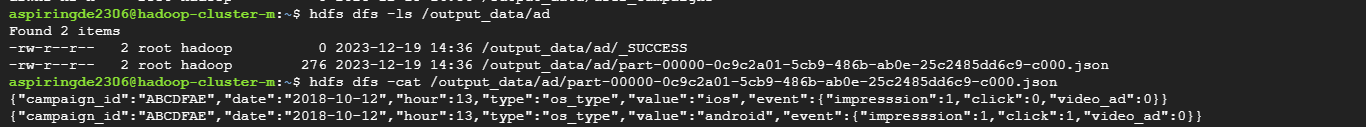

#### ads_external hive table output

CREATE EXTERNAL TABLE ads_external (
  campaign_id STRING,
  `date` DATE,
  hour INT,
  type STRING,
  value STRING,
  event MAP<STRING, INT>
)
ROW FORMAT SERDE 'org.apache.hive.hcatalog.data.JsonSerDe'
STORED AS TEXTFILE
LOCATION '/output_data/ad/';

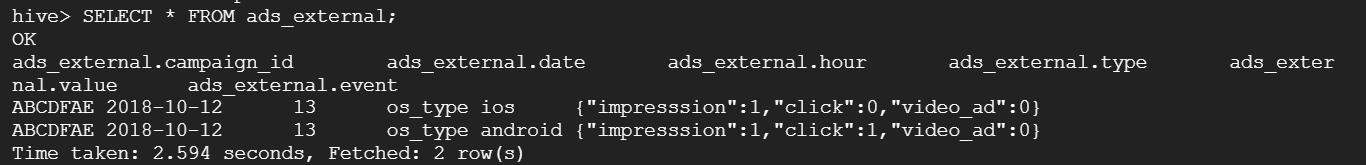

#### Q2.Analyse data for each campaign_id, date, hour, store_name & value to get all the events with counts

In [226]:
joined_df = ad_campaigns_df.alias('ad').join(stores_df.alias('stores'), expr('array_contains(stores.place_ids, ad.place_id)'), 'inner') \
        .withColumn('date', to_date(col('event_time'))) \
        .withColumn('hour', hour(col('event_time'))) \
        .withColumn('type', lit('store_name')) \
        .withColumn('value', col('store_name')) \
        .groupby('campaign_id', 'date', 'hour', 'type', 'value') \
        .agg(
            create_map(
                lit('impression'), count(when (col('event_type') == 'impression', True)),
                lit('video ad'), count(when (col('event_type') == 'video ad', True)),
                lit('click'), count(when (col('event_type') == 'click', True))
        ).alias('event')
)                                 

In [227]:
joined_df.show(truncate=False)

+-----------+----------+----+----------+-------------+--------------------------------------------+
|campaign_id|date      |hour|type      |value        |event                                       |
+-----------+----------+----+----------+-------------+--------------------------------------------+
|ABCDFAE    |2018-10-12|13  |store_name|BurgerKing   |{impression -> 1, video ad -> 0, click -> 1}|
|ABCDFAE    |2018-10-12|13  |store_name|shoppers stop|{impression -> 0, video ad -> 1, click -> 0}|
|ABCDFAE    |2018-10-12|13  |store_name|McDonald     |{impression -> 2, video ad -> 0, click -> 1}|
+-----------+----------+----+----------+-------------+--------------------------------------------+



In [228]:
# writing output data to hdfs 
joined_df.write.format('json').option('multiline', 'true').save('/output_data/store_campaigns')
print('Write Successfull')

Write Successfull


#### output data is written to hdfs

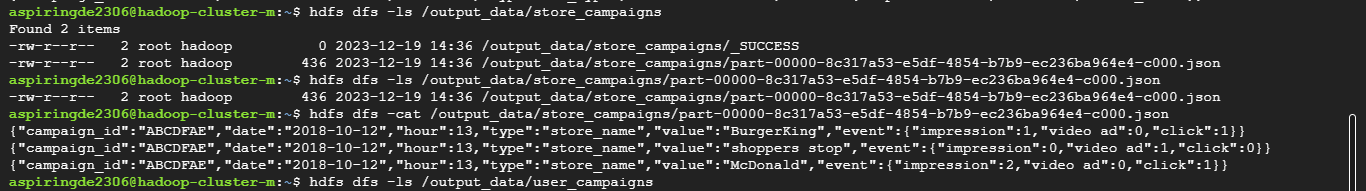

#### store_campaigns_external hive table output

CREATE EXTERNAL TABLE store_campaigns_external (
  campaign_id STRING,
  `date` DATE,
  hour INT,
  type STRING,
  value STRING,
  event MAP<STRING, INT>
)
ROW FORMAT SERDE 'org.apache.hive.hcatalog.data.JsonSerDe'
STORED AS TEXTFILE
LOCATION '/output_data/store_campaigns/';

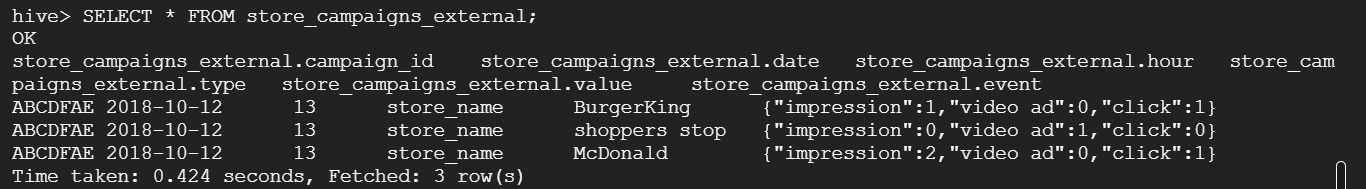

#### Q3.Analyse data for each campaign_id, date, hour, gender_type & value to get all the events with counts

In [244]:
combined_df = ad_campaigns_df.alias('ad').join(users_profile_df.alias('users'), (col('ad.campaign_country') == col('users.country')) & (col('ad.user_id') == col('users.user_id')), 'inner') \
        .withColumn('date', to_date(col('event_time'))) \
        .withColumn('hour', hour(col('event_time'))) \
        .withColumn('type', lit('gender')) \
        .withColumn('value', col('gender')) \
        .groupby('campaign_id', 'date', 'hour', 'type', 'value') \
        .agg(
            create_map(
                lit('impression'), count(when (col('event_type') == 'impression', True)),
                lit('click'), count(when (col('event_type') == 'click', True)),
                lit('video ad'), count(when (col('event_type') == 'video ad', True))
            ).alias('event')
)

In [245]:
combined_df.show(truncate=False)

+-----------+----------+----+------+------+--------------------------------------------+
|campaign_id|date      |hour|type  |value |event                                       |
+-----------+----------+----+------+------+--------------------------------------------+
|ABCDFAE    |2018-10-12|13  |gender|male  |{impression -> 1, click -> 1, video ad -> 1}|
|ABCDFAE    |2018-10-12|13  |gender|female|{impression -> 1, click -> 0, video ad -> 0}|
+-----------+----------+----+------+------+--------------------------------------------+



In [246]:
# writing output data to hdfs 
combined_df.write.format('json').option('multiline', 'true').save('/output_data/user_campaigns')
print('Write Successfull')

Write Successfull


#### output data is written to hdfs

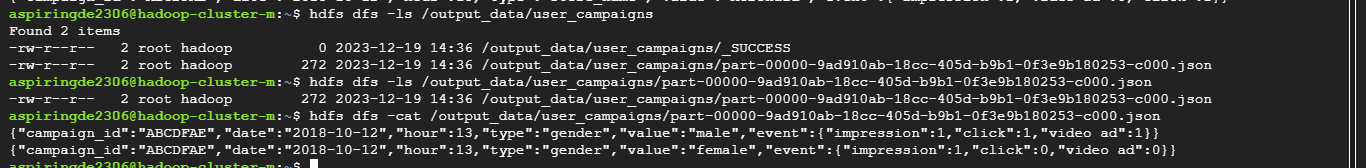

#### user_campaigns_external hive table output

CREATE EXTERNAL TABLE user_campaigns_external (
  campaign_id STRING,
  `date` DATE,
  hour INT,
  type STRING,
  value STRING,
  event MAP<STRING, INT>
)
ROW FORMAT SERDE 'org.apache.hive.hcatalog.data.JsonSerDe'
STORED AS TEXTFILE
LOCATION '/output_data/user_campaigns/';

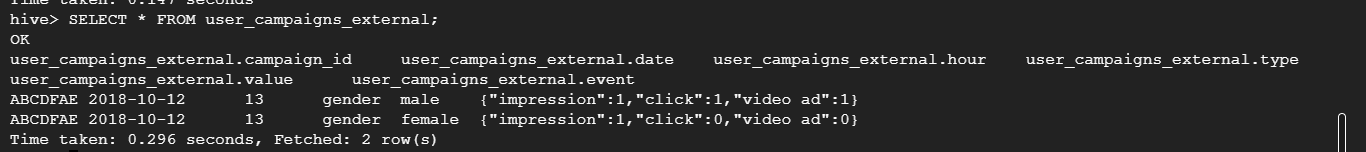